In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re
import math
from nltk.corpus import stopwords
import pdb
import warnings
from sklearn.model_selection import train_test_split
from collections import OrderedDict


import multiprocessing
import nltk
from nltk import FreqDist
from collections import Counter
import random
import gensim.models.word2vec as w2v
from sklearn.feature_extraction.text import CountVectorizer
import sklearn.manifold

In [2]:
nltk.download("stopwords")
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [3]:
from google.colab import files 


uploaded = files.upload() 

Saving master_scrapped_data.csv to master_scrapped_data.csv


In [4]:
data = pd.read_csv('master_scrapped_data.csv')

In [5]:
data.head()

Link  ...  Category
0  https://abcnews.go.com/Health/texas-front-line...  ...    Health
1  https://abcnews.go.com/Politics/pompeo-invites...  ...  Politics
2  https://abcnews.go.com/US/york-autonomous-zone...  ...        US
3  https://abcnews.go.com/US/104-year-wwii-vetera...  ...        US
4  https://abcnews.go.com/Politics/cdc-encourage-...  ...  Politics

[5 rows x 4 columns]

In [6]:
data.isna().sum()

Link        1
Title       8
Content     8
Category    2
dtype: int64

In [7]:
data[data.isna().any(axis=1)]

Link  ...       Category
164    https://abcnews.go.com/Health/covid-free-count...  ...         Health
192    https://abcnews.go.com/US/faces-coronavirus-pa...  ...            NaN
193                                                  NaN  ...            NaN
1304   https://abcnews.go.com/International/putin-don...  ...  International
3729   https://abcnews.go.com/Health/frenchman-dies-s...  ...         Health
3730   https://abcnews.go.com/Politics/high-dollar-tr...  ...       Politics
3731   https://abcnews.go.com/US/trumps-quest-dominat...  ...             US
6592   https://abcnews.go.com/Sports/paul-george-clip...  ...         Sports
12525  https://abcnews.go.com/Politics/trump-ignores-...  ...       Politics
12624  https://abcnews.go.com/Politics/biden-launch-3...  ...       Politics

[10 rows x 4 columns]

In [8]:
data.dropna(inplace=True)
data.drop_duplicates(subset='Link',inplace=True)
data.reset_index(drop=True,inplace=True)
data.isna().sum()

Link        0
Title       0
Content     0
Category    0
dtype: int64

In [9]:
data.shape

(18916, 4)

In [10]:
data.Category.unique()

array(['Health', 'Politics', 'US', 'Technology', 'Business',
       'International', 'Sports', 'Entertainment', 'ThisWeek',
       'abcnewsnow', 'GMA', '2020', 'ABCNews', 'Photos', 'WNT',
       'Lifestyle', 'WhatWouldYouDo', 'PollingUnit', 'theview', 'News',
       'Test', 'ABC_Univision', 'Staging', 'Blotter', 'Travel',
       'Social_Climber', 'Press_Release'], dtype=object)

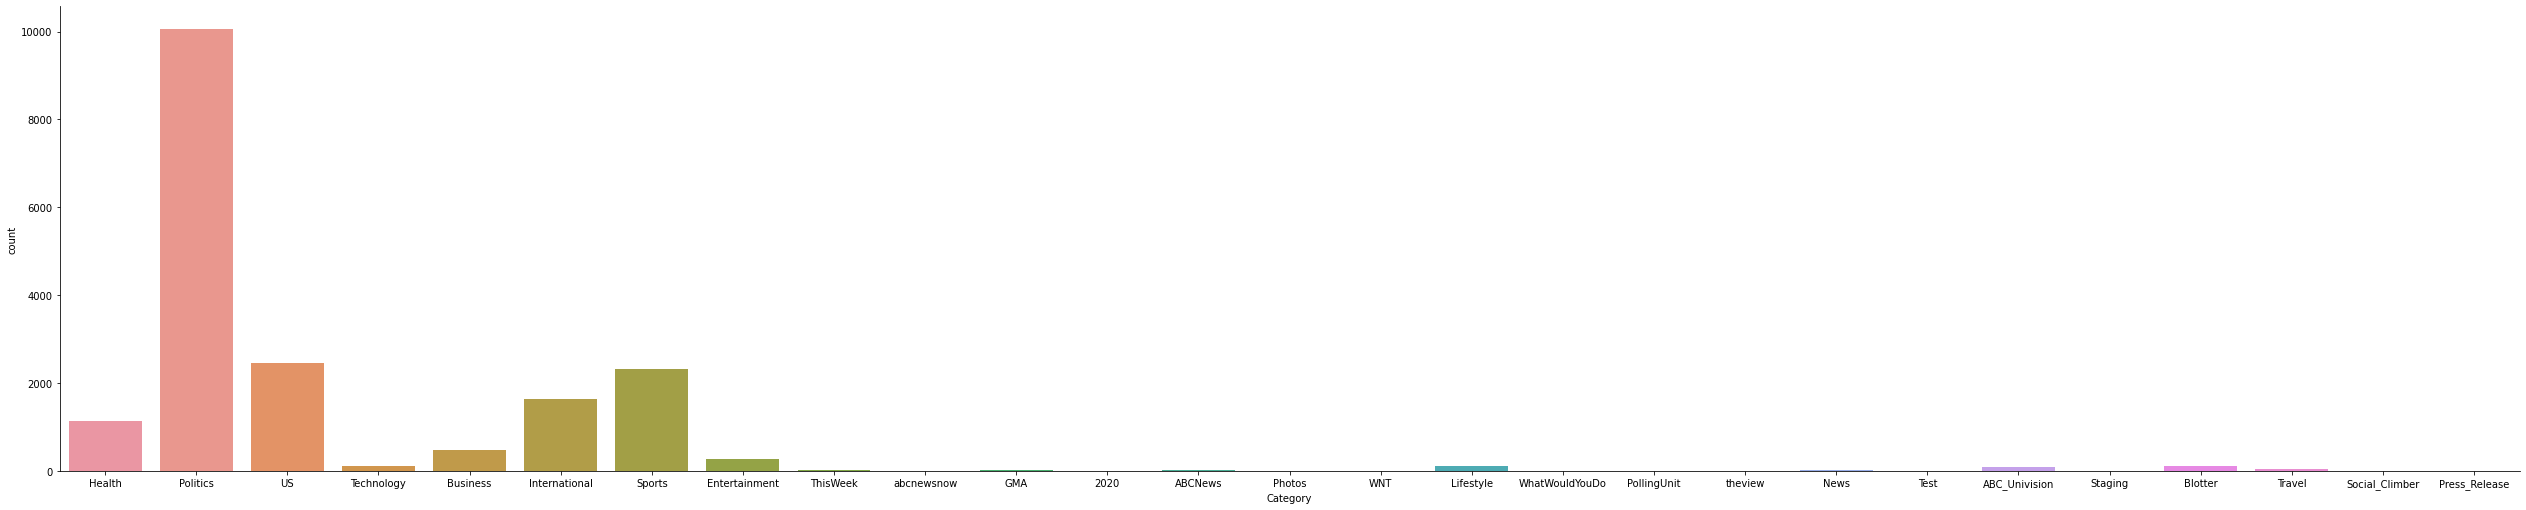

In [11]:
sns.catplot(x="Category", kind="count", data=data, height = 7, aspect = 5.0)

In [12]:
# loading stop words from nltk library
stop_words = set(stopwords.words('english'))

# referenced from https://stackoverflow.com/questions/23996118/replace-special-characters-in-a-string-python
# and https://pythonexamples.org/python-replace-multiple-spaces-with-single-space-in-text-file/

def sentence_split(text):
    """
    The sentences following 'MORE:' in the 'Content' feature are backlinks for other articles. Consequently, it becomes 
    irrelevant for that particular news article and so we remove it. The sent_tokenize then splits the paragraphs 
    into indivisual snetences.
    """
    text = re.sub(r'(?=MORE:)(.*)','',text)
    text = nltk.sent_tokenize(text)
    return text

def sentence_cleaner(text):
    new_text = []
    for sentence in text:
        sentence = sentence.lower()
        sentence = re.sub("((\S+)?(http(S)?)(\S+))|((\S+)?(www)(\S+))|((\S+)?(\@)(\S+)?)"," ", sentence)
        sentence = re.sub('[^a-zA-Z0-9\n]',' ', sentence)
        sentence = nltk.word_tokenize(sentence)
        sentence = [word for word in sentence if word not in stop_words and len(word)>1]
        new_text.append(sentence)
    return new_text

def final_tokenizer(text):
    return sentence_cleaner(sentence_split(text))

In [13]:
data['tokenized_words'] = data['Content'].apply(final_tokenizer)

In [14]:
data.head()

Link  ...                                    tokenized_words
0  https://abcnews.go.com/Health/texas-front-line...  ...  [[texas, doctor, treated, covid, 19, patients,...
1  https://abcnews.go.com/Politics/pompeo-invites...  ...  [[despite, warnings, top, health, officials, a...
2  https://abcnews.go.com/US/york-autonomous-zone...  ...  [[protesters, waving, american, flags, slammin...
3  https://abcnews.go.com/US/104-year-wwii-vetera...  ...  [[world, war, ii, veteran, defeated, covid, 19...
4  https://abcnews.go.com/Politics/cdc-encourage-...  ...  [[voted, stickers, vaccinated, covid, 19, butt...

[5 rows x 5 columns]

In [15]:
all_words = list(data['tokenized_words'])
all_words = [subitem for item in all_words for subitem in item]

In [16]:
num_features = 300
min_word_count = 10
num_workers = multiprocessing.cpu_count()
window_size = 10
downsampling = 1e-3
seed = 1

In [17]:
word2vec = w2v.Word2Vec(
    sg=1,
    seed=seed,
    workers=num_workers,
    size=num_features,
    min_count=min_word_count,
    window=window_size,
    sample=downsampling
)

In [18]:
word2vec.build_vocab(all_words)

In [19]:
print("Word2Vec vocabulary length:", len(word2vec.wv.vocab))

Word2Vec vocabulary length: 27430


In [20]:
word2vec.train(all_words, total_examples=word2vec.corpus_count, epochs=word2vec.epochs)

(38878841, 40835200)

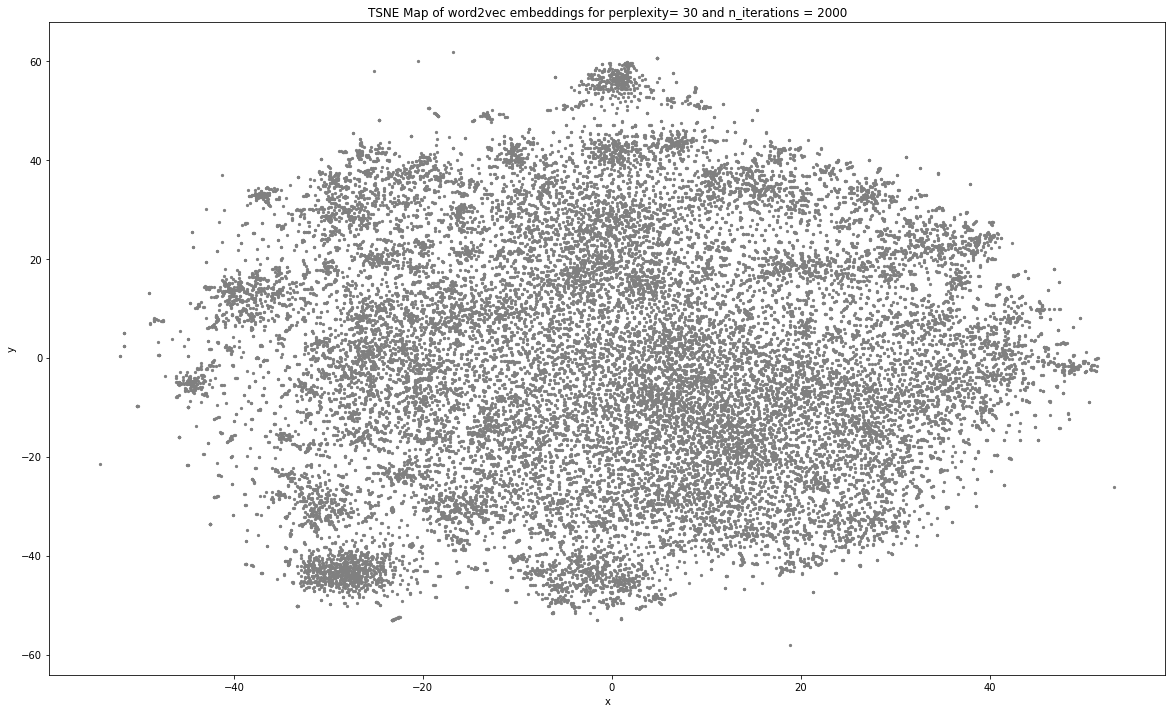

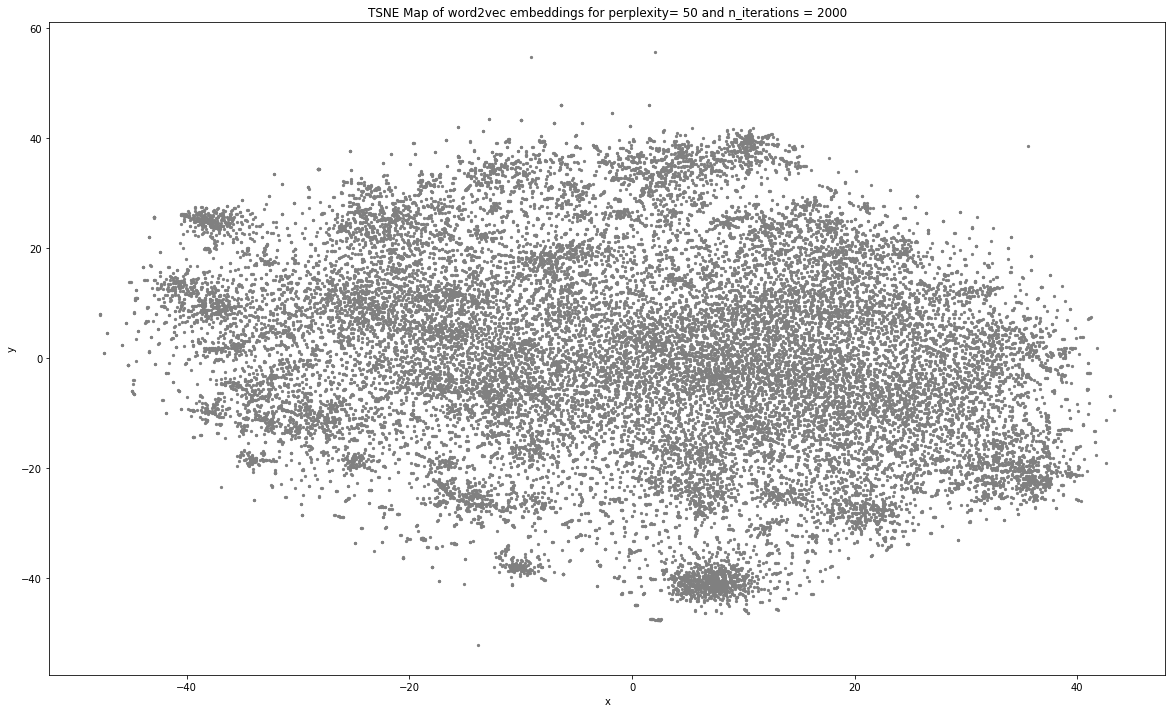

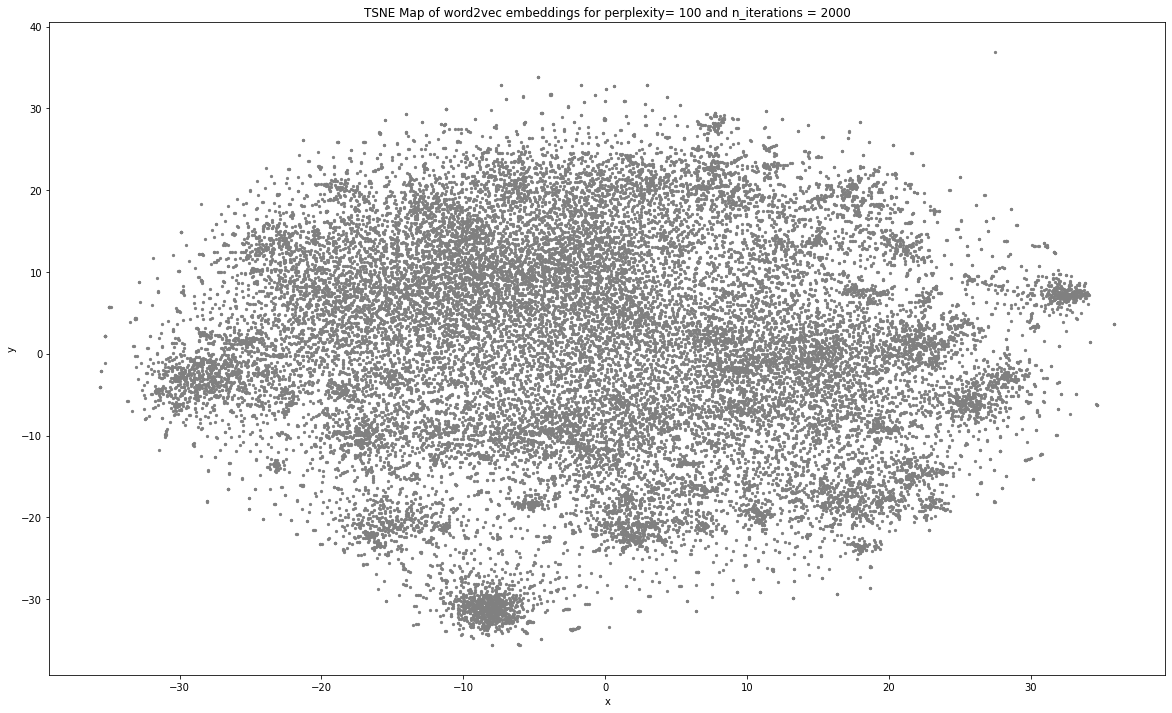

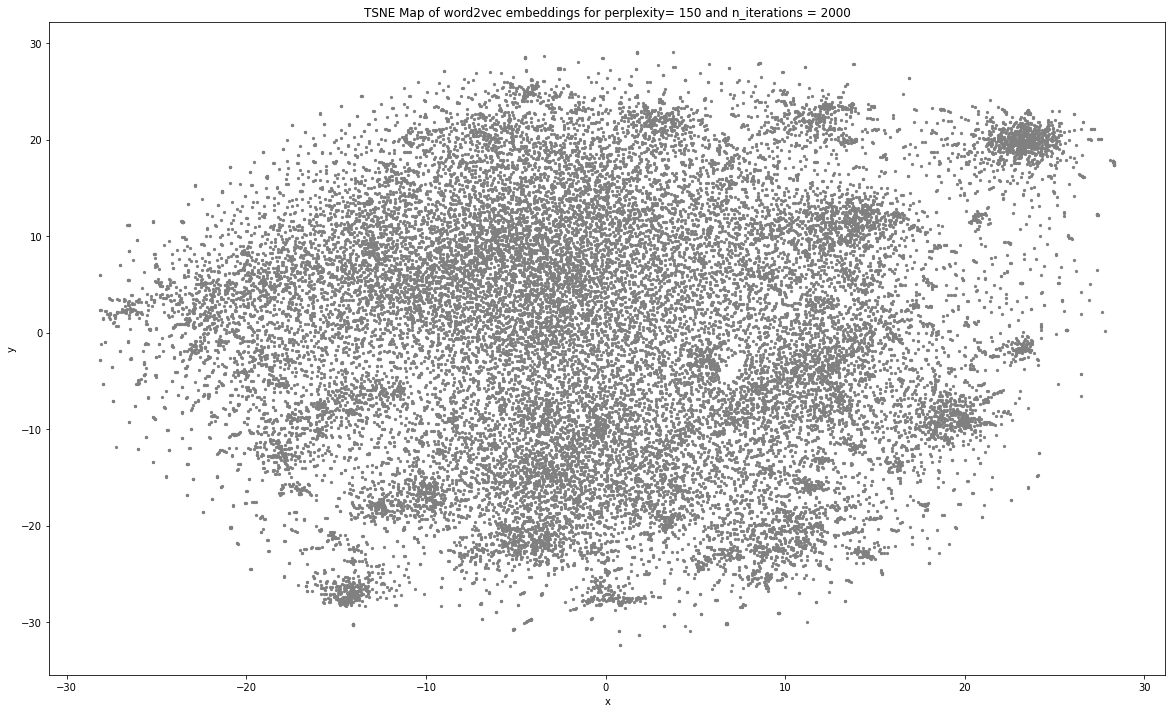

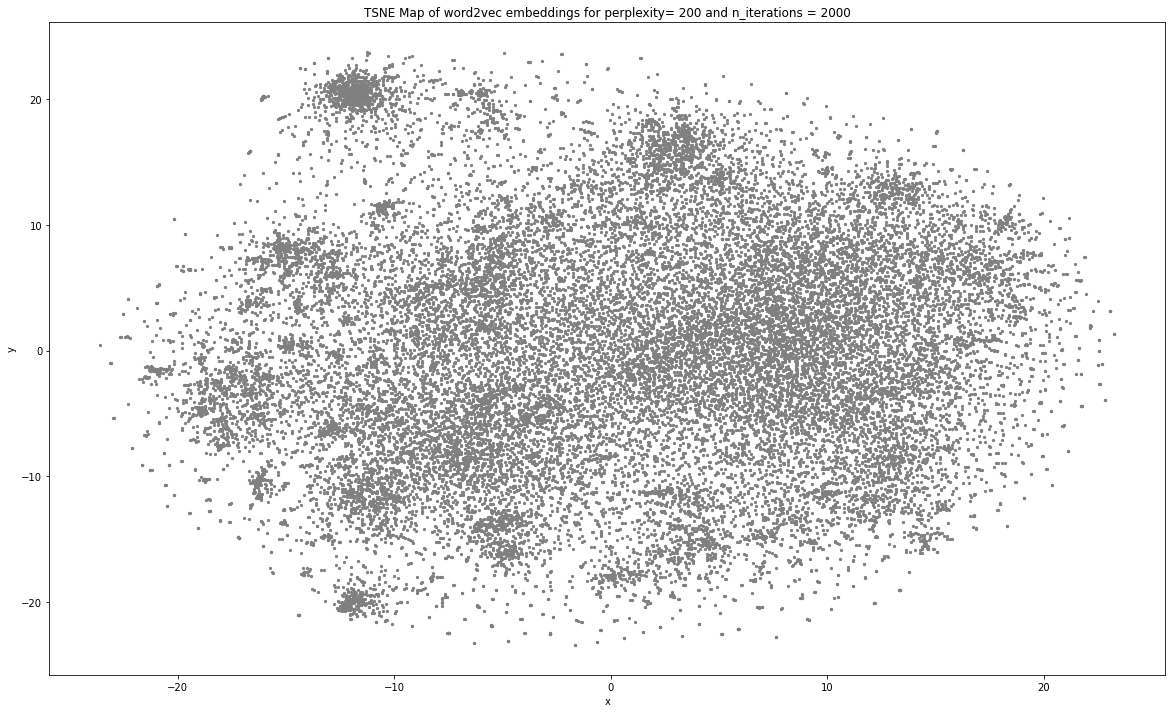

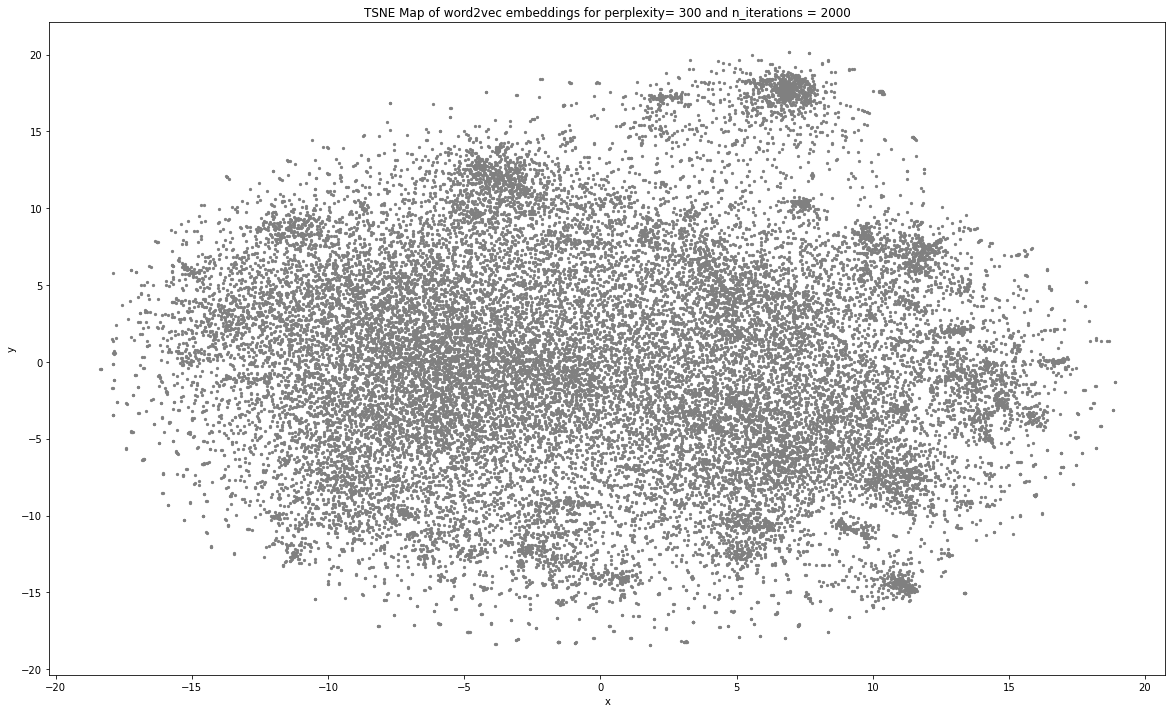

In [21]:
all_word_vectors_matrix = word2vec.wv.vectors

perplex = [30,50,100,150,200,300]
for i in perplex:
    
    tsne = sklearn.manifold.TSNE(n_components=2, random_state=0, perplexity=i, n_iter=1000, n_jobs=-1)
    all_word_vectors_matrix_2d = tsne.fit_transform(all_word_vectors_matrix)

    points = pd.DataFrame(
        [
            (word, coords[0], coords[1])
            for word, coords in [
                (word, all_word_vectors_matrix_2d[word2vec.wv.vocab[word].index])
                for word in word2vec.wv.vocab
            ]
        ],
        columns=["word", "x", "y"]
    )


    title = 'TSNE Map of word2vec embeddings for perplexity= '+str(i)+' and n_iterations = 2000'
    points.plot.scatter("x", "y", s=5, figsize=(20, 12), title=title, c='grey')

As we can see above that for perplexity ranging from 100-200 the tsne map does not show much change. Hence, in order to find out the optimum perplexity value, I decided to go ahead with 'perplexity = sqrt(N)' i.e. Perplexity = 165 (referenced from https://towardsdatascience.com/how-to-tune-hyperparameters-of-tsne-7c0596a18868). Now we'll be increasing the iterations to check if the results improve further. 

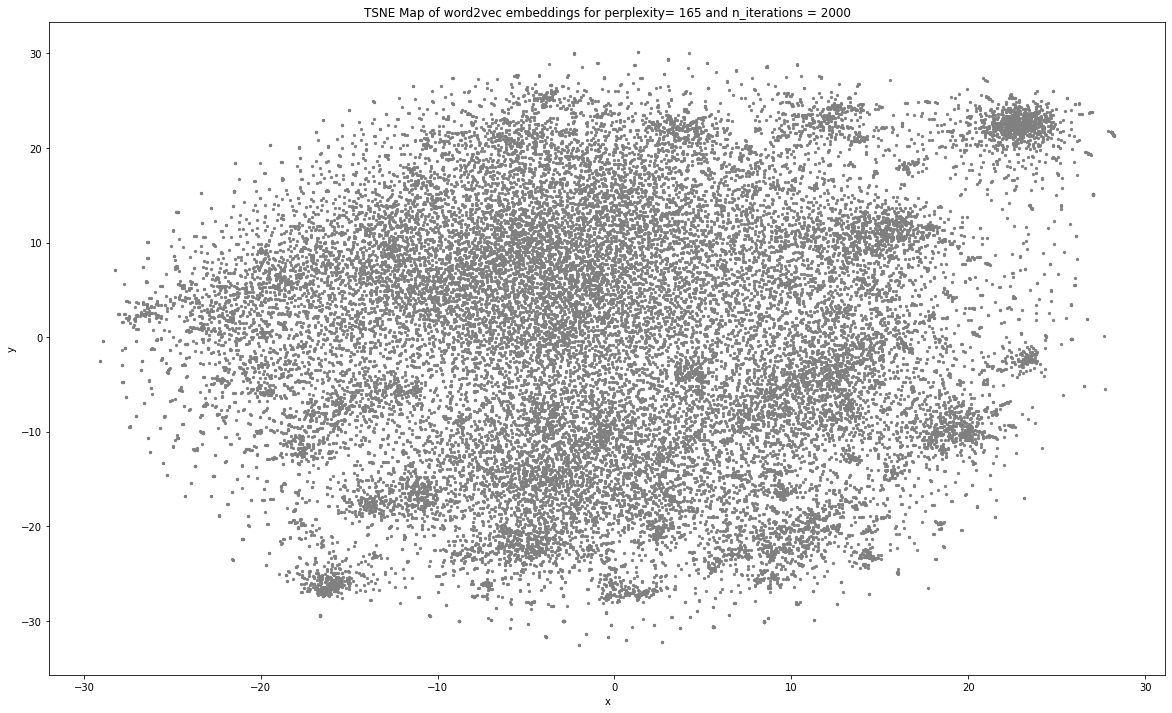

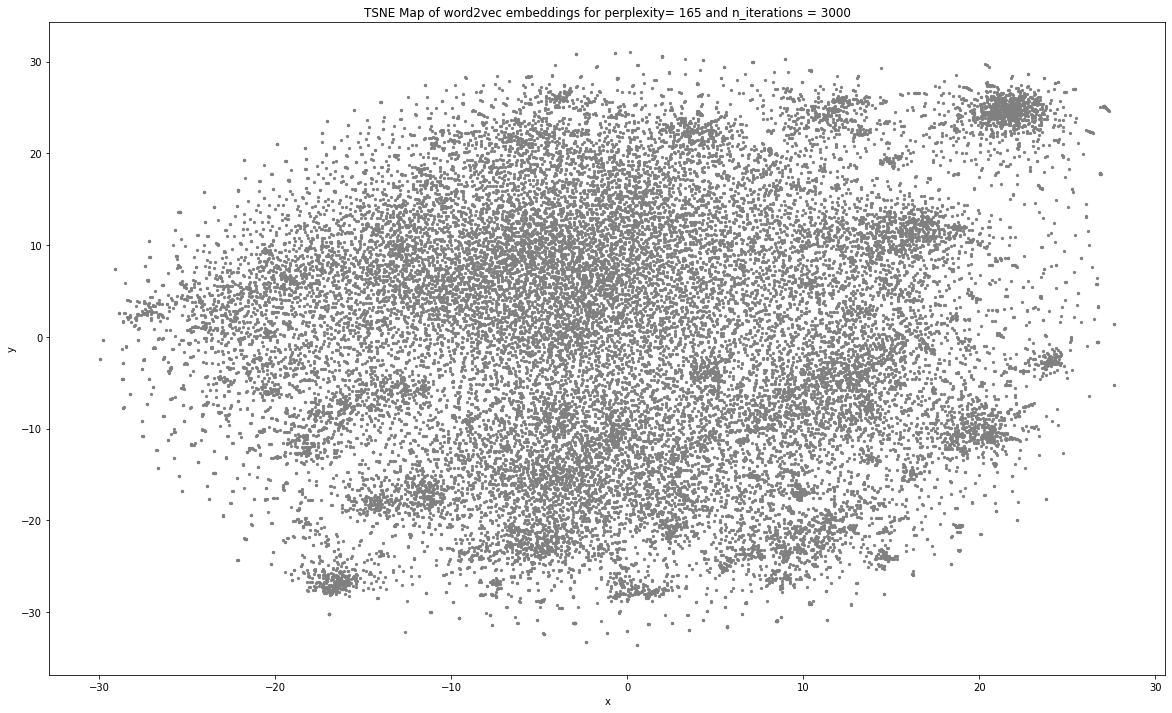

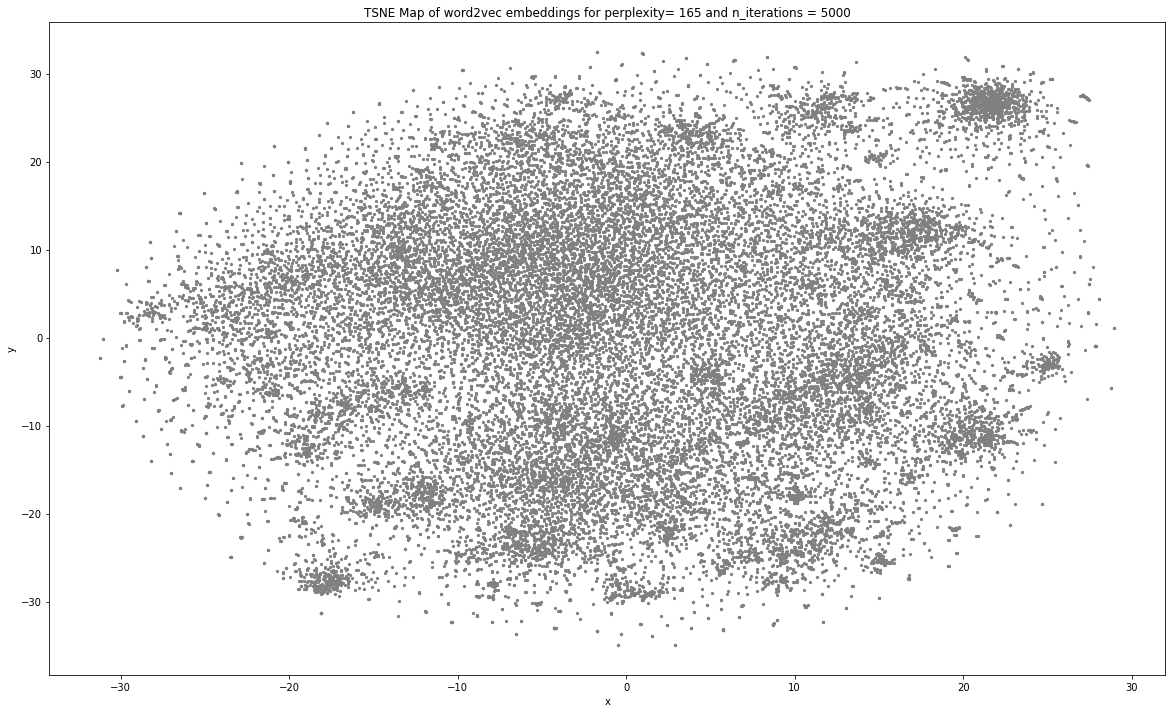

In [23]:
iter = [2000,3000,5000]

for i in iter:
    
    tsne = sklearn.manifold.TSNE(n_components=2, random_state=0, perplexity=165, n_iter=i, n_jobs=-1)
    all_word_vectors_matrix_2d = tsne.fit_transform(all_word_vectors_matrix)

    points = pd.DataFrame(
        [
            (word, coords[0], coords[1])
            for word, coords in [
                (word, all_word_vectors_matrix_2d[word2vec.wv.vocab[word].index])
                for word in word2vec.wv.vocab
            ]
        ],
        columns=["word", "x", "y"]
    )
    title = 'TSNE Map of word2vec embeddings for perplexity= 165 and n_iterations = '+str(i)
    points.plot.scatter("x", "y", s=5, figsize=(20, 12), title=title, c='grey')

There is no notable difference when increasing the number of iterations. Hence, we can infer that tsne is perfectly stable at perplexity = 165.

In [24]:
b = []
for k,v in data.iterrows():
    a = re.sub(r'(?=MORE:)(.*)','',v.Content)
    a = a.lower()
    a = re.sub("((\S+)?(http(S)?)(\S+))|((\S+)?(www)(\S+))|((\S+)?(\@)(\S+)?)", " ", a)
    a = re.sub('[^a-zA-Z0-9\n]',' ', a)
    a = nltk.word_tokenize(a)
    a = dict(Counter(a))
    b.append(a)
    
data['word_count'] = b

In [25]:
data.head()

Link  ...                                         word_count
0  https://abcnews.go.com/Health/texas-front-line...  ...  {'a': 7, 'texas': 2, 'doctor': 3, 'who': 1, 't...
1  https://abcnews.go.com/Politics/pompeo-invites...  ...  {'despite': 1, 'warnings': 1, 'by': 5, 'top': ...
2  https://abcnews.go.com/US/york-autonomous-zone...  ...  {'protesters': 2, 'waving': 1, 'american': 1, ...
3  https://abcnews.go.com/US/104-year-wwii-vetera...  ...  {'a': 4, 'world': 4, 'war': 3, 'ii': 2, 'veter...
4  https://abcnews.go.com/Politics/cdc-encourage-...  ...  {'if': 3, 'there': 1, 'are': 2, 'i': 2, 'voted...

[5 rows x 6 columns]

In [26]:
def search_index(c):
    
    pd.set_option('display.max_colwidth', -1)
    global input_str
    
    c = c.lower()
    c = re.sub("((\S+)?(http(S)?)(\S+))|((\S+)?(www)(\S+))|((\S+)?(\@)(\S+)?)", " ", c)
    c = re.sub('[^a-zA-Z0-9\n]',' ',c)

    d = list(c.split())
    input_str = list(set([word for word in d if word not in stop_words]))
    print(input_str)
    e = OrderedDict()
    f = []
    temp=[]

    for index,content in data.iterrows():
        prime_count = 0
        count = 0
        points = 0
        for i in input_str:
            if i in content['Title']: 
                prime_count +=1
                if i in (content['word_count']).keys():
                    #pdb.set_trace()
                    count += 1                           # considering how many words from the input match with the content
                    points += content['word_count'][i]   # considering the number of times those words occur in the content corpus
            else:
                if i in (content['word_count']).keys():
                    #pdb.set_trace()
                    count += 1
                    points += content['word_count'][i]
                    
        if len(input_str)<=3:
            if count>=1:
                e[index] = {'prime_count':prime_count,'count':count,'points':points}
                
        elif 3 < len(input_str) <=5:
            if count>=2:
                e[index] = {'prime_count':prime_count,'count':count,'points':points}
                
        elif len(input_str) > 5:
            if count>=3:
                e[index] = {'prime_count':prime_count,'count':count,'points':points}
                

    # the lambda function first sorts the dictionary based on the 'count' and then on the basis of 'points'
    
    for key,val in sorted(e.items(), key=lambda kv: (kv[1]['prime_count'],kv[1]['count'],kv[1]['points']),reverse=True):
        f.append(key)
        #print(key,val)

    
    print('\nTotal number of results: ',len(f))    

    if len(f)>50 :
        temp=f[:50]
        #print(temp)
        print('\nTop 50 results:\n')
        a = data.iloc[temp,[0,1,2,3]].copy()
    else:
        a = data.iloc[f,[0,1,2,3]].copy()
        
    #print(a,'\n')
    print(a)

In [27]:
def reality_check(c):
    
    w = nltk.sent_tokenize(c)
    w = sentence_cleaner(w)
    print(w)
    # w = [words for words in inp_list if words in word2vec.wv.vocab]
    sum_points = 0
    counter = 0
    top5 = 5
    x = OrderedDict()
    y = OrderedDict()
    similar = OrderedDict()
    
    for i in w:

      for f in i:
        try:
          temp_count = word2vec.wv.vocab[f]
          y[f] = temp_count.count
        except:
          continue

      if len(i)>=3:
        
        for j in range(len(i)-2):
          try:
            a = word2vec.wv.similarity(i[j],i[j+1])
            x[a] = [i[j],i[j+1]]
            sum_points += a
            counter += 1
            a = word2vec.wv.similarity(i[j],i[j+2])
            x[a] = [i[j],i[j+2]]
            sum_points += a
            counter += 1
          except:
            continue

        a = word2vec.wv.similarity(i[len(i)-2],i[len(i)-1])
        x[a] = [i[len(i)-2],i[len(i)-1]]
        sum_points += a
        counter += 1
        
      elif len(i)==2:
        a = word2vec.wv.similarity(i[0],i[1])
        x[a] = [i[0],i[1]]
        sum_points += a
        counter += 1

      else:
        sim = word2vec.wv.most_similar(i[0],topn=20)
        print('\n','-'*100,'\n',f'The top 20 words related to {w} are:\n')
        for i in sim:
            print(i)
        print('\n','-'*100)
      
    
    if counter>=1:
      similar = sorted(y.items(), key=lambda kv:(kv[1]), reverse=True)
      print('-'*200)
      print('The following is a list of most common words found in your input corpus and other words which are most similar to them:\n')
      if len(similar)>5:
        for i in range(0,5):
          print(f'{similar[i][0]}:')
          print(word2vec.wv.most_similar(similar[i][0],topn=5),'\n')
        
      else:
        for i in range(len(similar)):
          print(f'{similar[i][0]}:')
          print(word2vec.wv.most_similar(similar[i][0],topn=5),'\n')


      print('-'*200)
      similarity = sorted(x.items(), key=lambda kv:(kv[0]), reverse=True)
      if len(similarity)>5:
        print('\n\nTop 5 similar words in the input corpus are:')
        for i in range(0,5):
          print(similarity[i])
      else:
        print('\n\nTop similar words in the input corpus are:')
        for i in range(len(similarity)):
          print(similarity[i])

            

      print('\n')
      avg = sum_points/counter
      print('-'*200)
      print(f'On a scale of [0-1] the score of your content is: {avg}')
      print('-'*200)

In [28]:
def user_ask():
    a = input('Please choose your desired path-\n[0]: Know more about a topic\n[1]: Fact check a piece of content\n\n')
    
    if int(a) == 0:
        b = input('Enter the topic you''re interested in:')
        search_index(b)
    
    elif int(a) == 1:
        b = input('Enter the content you want to fact check:')
        articles = search_index(b)
        articles
        reality_check(b)
        print('\n')
        trial = points[points['word'].isin(input_str)].copy()
        plt.figure(figsize=[20,12])
        plt.scatter(points.x, points.y, s=5, c='grey')
        plt.scatter(trial.x, trial.y,s=30, c='red')
        for i, point in trial.iterrows():
            a = point.x
            b = point.y
            plt.annotate(point.word, xy=(a+0.5,b+0.5))
        

Please choose your desired path-
[0]: Know more about a topic
[1]: Fact check a piece of content

1
Enter the content you want to fact check:Doctors have repeatedly suggested to wear masks. Still some people refuse to wear one.


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  This is separate from the ipykernel package so we can avoid doing imports until


['wear', 'one', 'people', 'masks', 'still', 'suggested', 'doctors', 'refuse', 'repeatedly']

Total number of results:  5141

Top 50 results:

                                                                                                                              Link  ...       Category
4298   https://abcnews.go.com/Politics/airlines-ban-passengers-refuse-wear-masks/story?id=71279833                                  ...  Politics     
2038   https://abcnews.go.com/Politics/trump-masks-wearing-public/story?id=71561790                                                 ...  Politics     
517    https://abcnews.go.com/Health/diy-masks-protect-covid-19-smart-wear/story?id=69957443                                        ...  Health       
1185   https://abcnews.go.com/US/officials-pushback-states-counties-require-people-wear-masks/story?id=71452988                     ...  US           
1121   https://abcnews.go.com/US/covid-19-controlled-months-people-wear-masks-cdc/story?id=71783194    

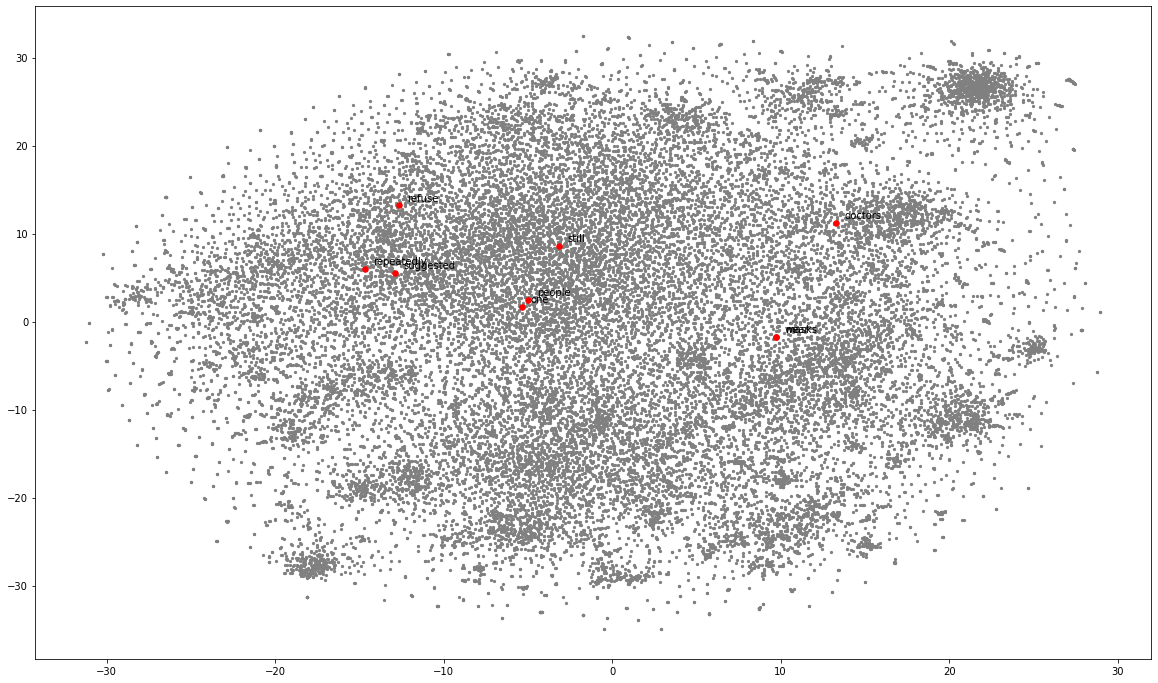

In [29]:
user_ask()